# AML: ASSIGNMENT 01 Deep Neural Network for MNIST

Rishika Tibrewal MDS202135 \
Shreyansh Rastogi MDS202144


## Data and Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import random

# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### **Load the MNIST dataset**
Observe that we set `shuffle=True`, which means that data is randomized

In [2]:
input_size  = 28*56   # images are 28x28 pixels
output_size = 100      # there are 100 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)
classNames = list(range(100))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



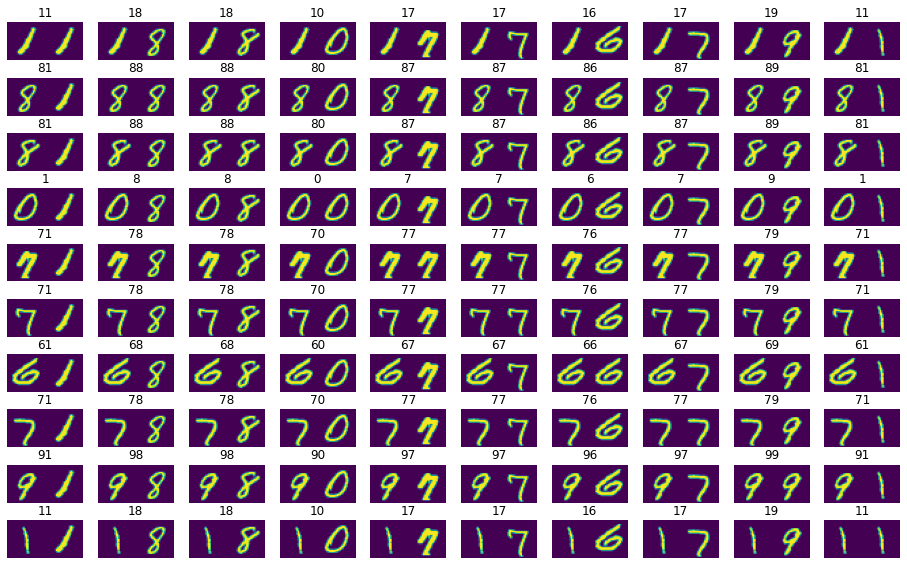

In [3]:
# show some training images
plt.figure(figsize=(16, 10))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))
image=[]
label=[]
for i in range(10):
    image.append(image_batch[i])
    label.append(label_batch[i].item())

for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, (10*i) + j + 1)
        # image, label = train_loader.dataset.__getitem__(i)
        curr = torch.cat((image[i],image[j]),2)
        plt.imshow(curr.squeeze().numpy())
        # imshow(image,plt)
        plt.axis('off')
        plt.title(classNames[((label[i]*10)+label[j])])

In [4]:
def double_digits(data,target):
    data_100,target_100=[],[]
    for i in range(len(data)):
        for j in range(len(data)):
            data_100.append(torch.cat((data[i],data[j]),2))
            target_100.append((target[i]*10)+target[j])
    return torch.stack(data_100),torch.stack(target_100)

## A 2-hidden layer Fully Connected Neural Network


### Helper functions for training and testing

In [5]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = double_digits(data,target)
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset)*10,
                100. * batch_idx /(len(train_loader)), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = double_digits(data,target)
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= (len(test_loader.dataset)*10)
    accuracy = 100. * correct / (len(test_loader.dataset)*10)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### Defining the Fully Connected Network

In [6]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 300), 
            nn.ReLU(), 
            nn.Linear(300,200),
            nn.ReLU(),
            nn.Linear(200,150), 
            nn.ReLU(), 
            nn.Linear(150, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

### Train the Network

In [10]:
print("Training on ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(),lr=0.01)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 15):
    train(epoch, model_fnn)
    test(model_fnn)

Training on  cpu
Number of parameters: 576150
Train Epoch: 0 [0/600000 (0%)]	Loss: 4.613170
Train Epoch: 0 [10000/600000 (2%)]	Loss: 4.594428
Train Epoch: 0 [20000/600000 (3%)]	Loss: 4.584970
Train Epoch: 0 [30000/600000 (5%)]	Loss: 4.572310
Train Epoch: 0 [40000/600000 (7%)]	Loss: 4.536194
Train Epoch: 0 [50000/600000 (8%)]	Loss: 4.544162
Train Epoch: 0 [60000/600000 (10%)]	Loss: 4.462259
Train Epoch: 0 [70000/600000 (12%)]	Loss: 4.179265
Train Epoch: 0 [80000/600000 (13%)]	Loss: 4.034011
Train Epoch: 0 [90000/600000 (15%)]	Loss: 3.601772
Train Epoch: 0 [100000/600000 (17%)]	Loss: 3.460066
Train Epoch: 0 [110000/600000 (18%)]	Loss: 2.840110
Train Epoch: 0 [120000/600000 (20%)]	Loss: 2.561733
Train Epoch: 0 [130000/600000 (22%)]	Loss: 2.647460
Train Epoch: 0 [140000/600000 (23%)]	Loss: 2.200814
Train Epoch: 0 [150000/600000 (25%)]	Loss: 2.016152
Train Epoch: 0 [160000/600000 (27%)]	Loss: 1.843133
Train Epoch: 0 [170000/600000 (28%)]	Loss: 1.658885
Train Epoch: 0 [180000/600000 (30%)]	L

### Show some predictions of the test network

In [8]:
def visualize_pred(img, pred_prob, real_label, pred_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(numpy.arange(100), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(100))
    ax2.set_yticklabels(numpy.arange(100))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

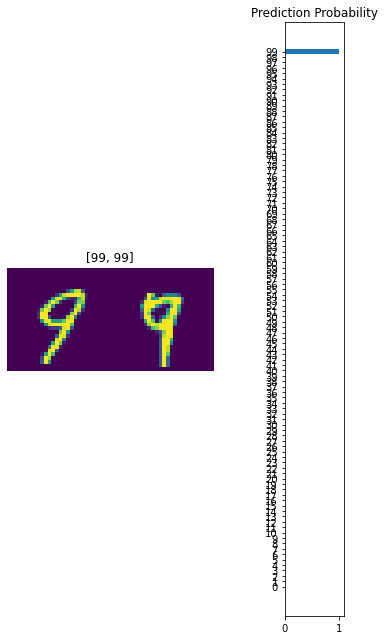

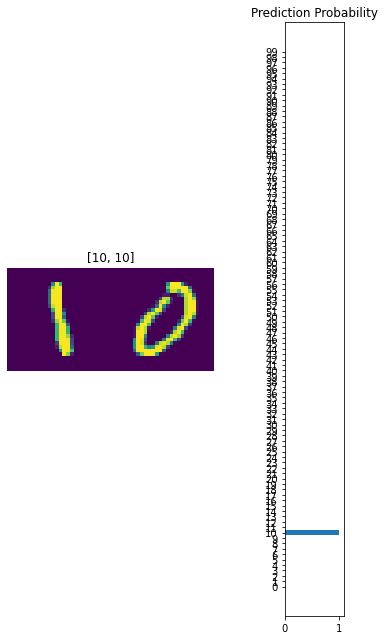

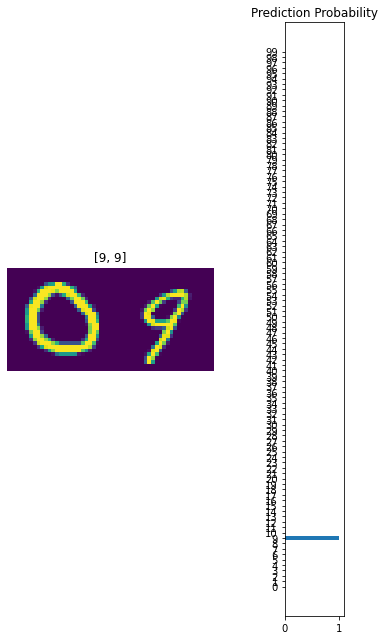

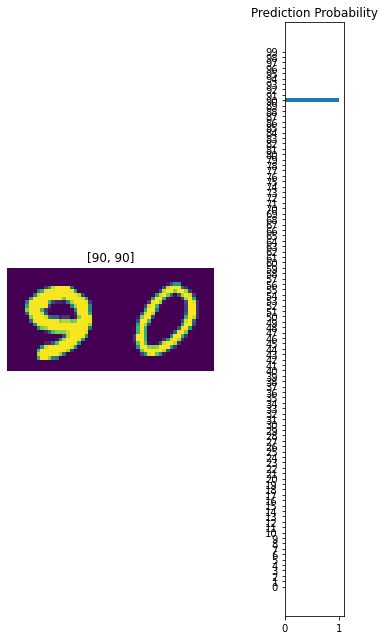

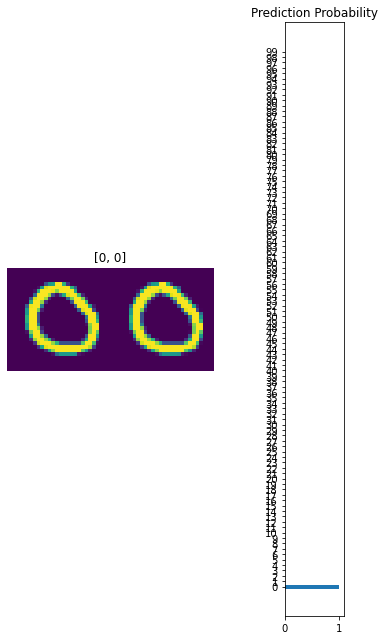

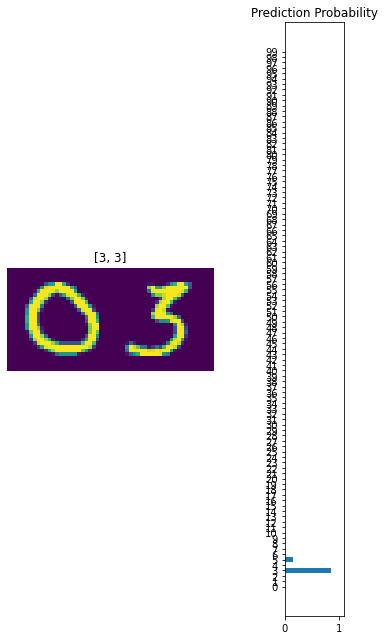

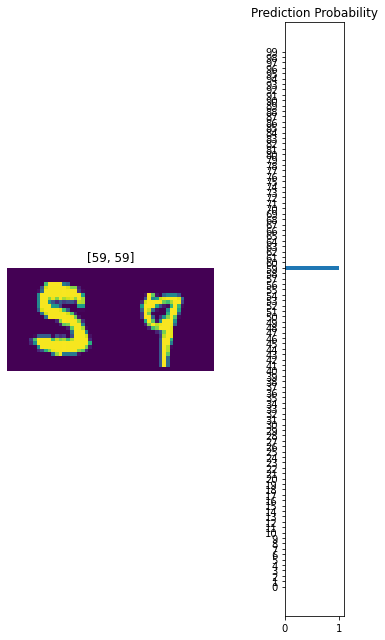

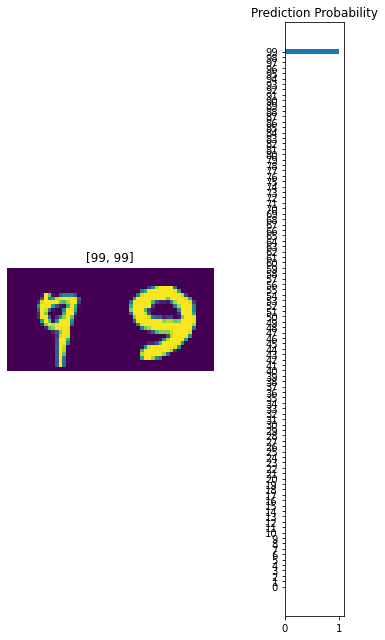

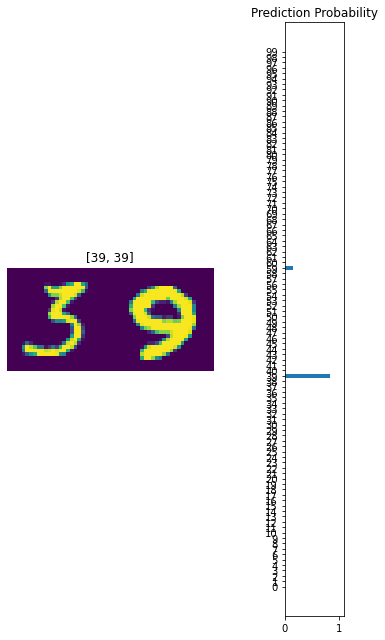

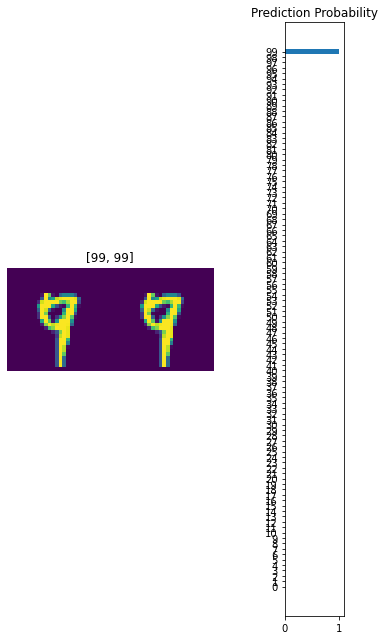

In [9]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch, label_batch = double_digits(image_batch,label_batch)

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(10):
    j=random.randint(0,99)
    img = image_batch[j]
    real_label = label_batch[j].item()
    log_pred_prob = log_pred_prob_batch[j]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    pred_label = numpy.argmax(pred_prob)
    # print(real_label, pred_label)
    visualize_pred(img, pred_prob, real_label, pred_label)

## Network with Dropout

In [11]:
class FC2LayerDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2LayerDropout, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 300),
            nn.Dropout(0.2),
            nn.ReLU(), 
            nn.Linear(300, 200),
            nn.Dropout(0.2),
            nn.ReLU(), 
            nn.Linear(200,150),
            nn.ReLU(),
            nn.Linear(150, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [12]:
print("With Dropout Training on ", device)
model = FC2LayerDropout(input_size, output_size)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 15):
    model.train() # model in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model)
    model.eval() # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    test(model)

With Dropout Training on  cpu
Number of parameters: 576150
Train Epoch: 0 [0/600000 (0%)]	Loss: 4.597708
Train Epoch: 0 [10000/600000 (2%)]	Loss: 4.595190
Train Epoch: 0 [20000/600000 (3%)]	Loss: 4.597950
Train Epoch: 0 [30000/600000 (5%)]	Loss: 4.563250
Train Epoch: 0 [40000/600000 (7%)]	Loss: 4.531586
Train Epoch: 0 [50000/600000 (8%)]	Loss: 4.508566
Train Epoch: 0 [60000/600000 (10%)]	Loss: 4.462644
Train Epoch: 0 [70000/600000 (12%)]	Loss: 4.385500
Train Epoch: 0 [80000/600000 (13%)]	Loss: 4.259662
Train Epoch: 0 [90000/600000 (15%)]	Loss: 4.247473
Train Epoch: 0 [100000/600000 (17%)]	Loss: 3.575315
Train Epoch: 0 [110000/600000 (18%)]	Loss: 3.156381
Train Epoch: 0 [120000/600000 (20%)]	Loss: 2.746186
Train Epoch: 0 [130000/600000 (22%)]	Loss: 2.215108
Train Epoch: 0 [140000/600000 (23%)]	Loss: 2.425307
Train Epoch: 0 [150000/600000 (25%)]	Loss: 1.346150
Train Epoch: 0 [160000/600000 (27%)]	Loss: 1.730555
Train Epoch: 0 [170000/600000 (28%)]	Loss: 2.022887
Train Epoch: 0 [180000/60

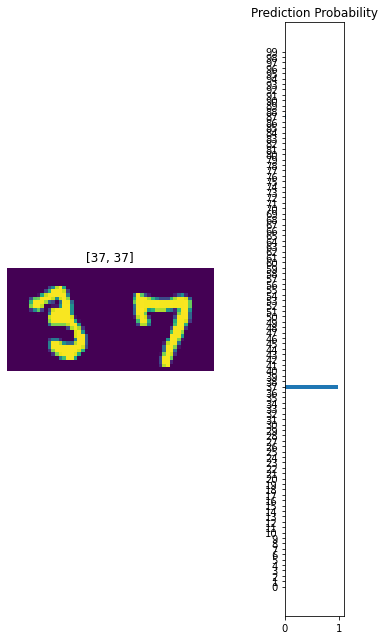

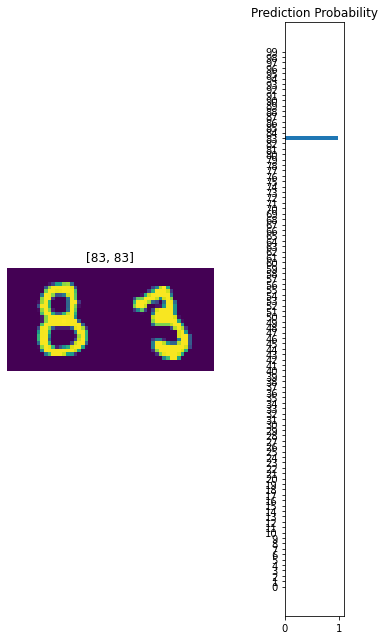

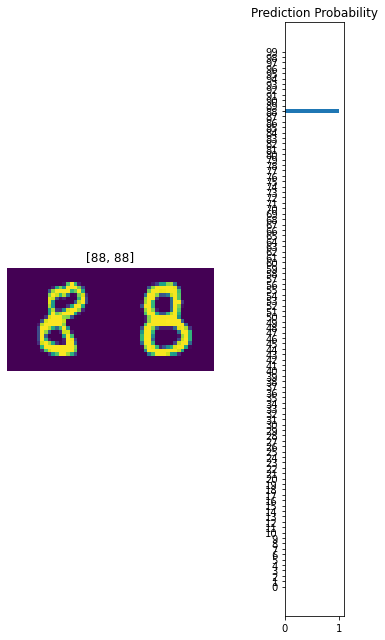

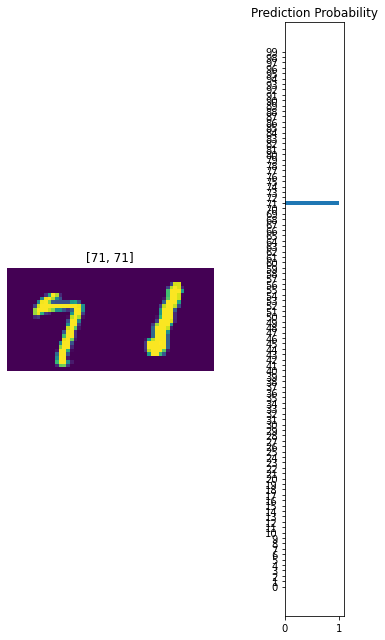

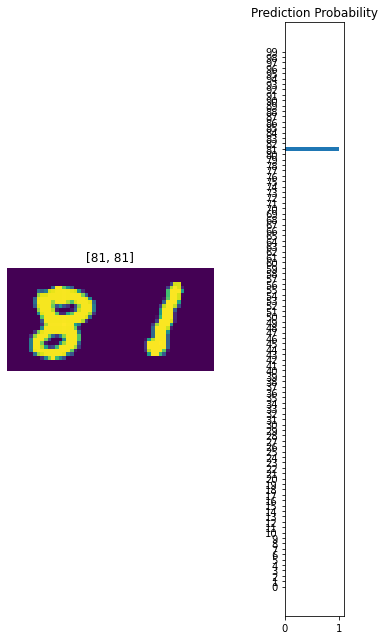

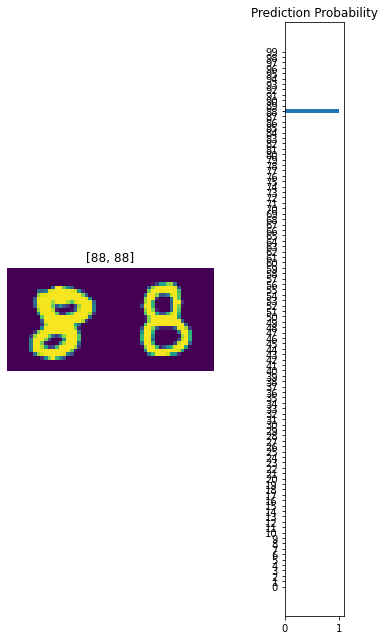

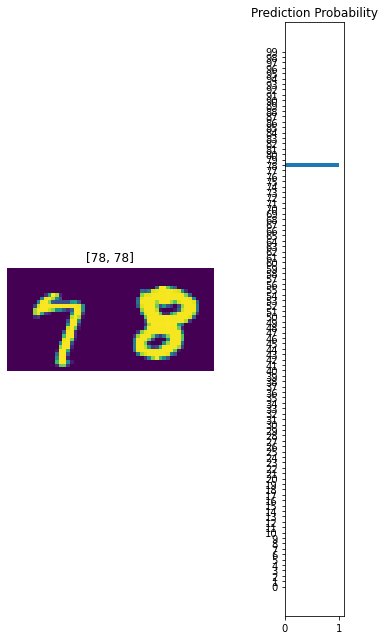

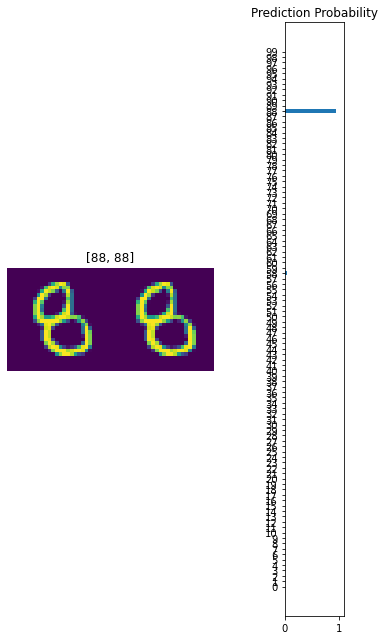

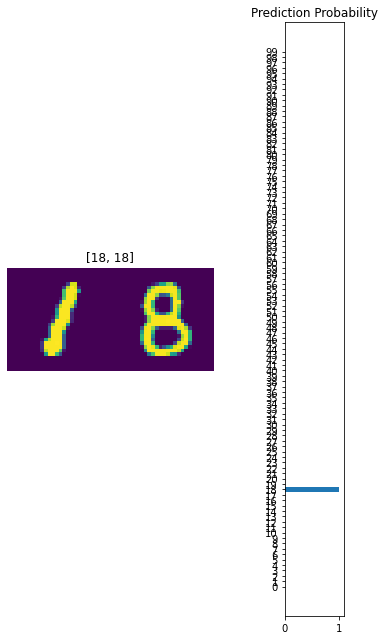

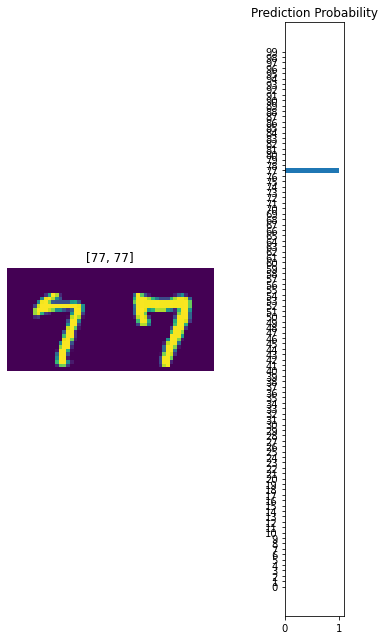

In [13]:
model.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch, label_batch = double_digits(image_batch,label_batch)

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model(image_batch)
for i in range(10):
    j=random.randint(0,99)
    img = image_batch[j]
    real_label = label_batch[j].item()
    log_pred_prob = log_pred_prob_batch[j]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    pred_label = numpy.argmax(pred_prob)
    # print(real_label, pred_label)
    visualize_pred(img, pred_prob, real_label, pred_label)